# Assignment 9: GBDT

In [75]:
import time
time_start = time.time()

import re
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

from statistics import mode
from tqdm import tqdm
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import nltk
# nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print(f'Number of data points in train data : {project_data.shape}')
print('\nColumn names : \n', project_data.columns)

project_data.head(2)

Number of data points in train data : (109248, 17)

Column names : 
 Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


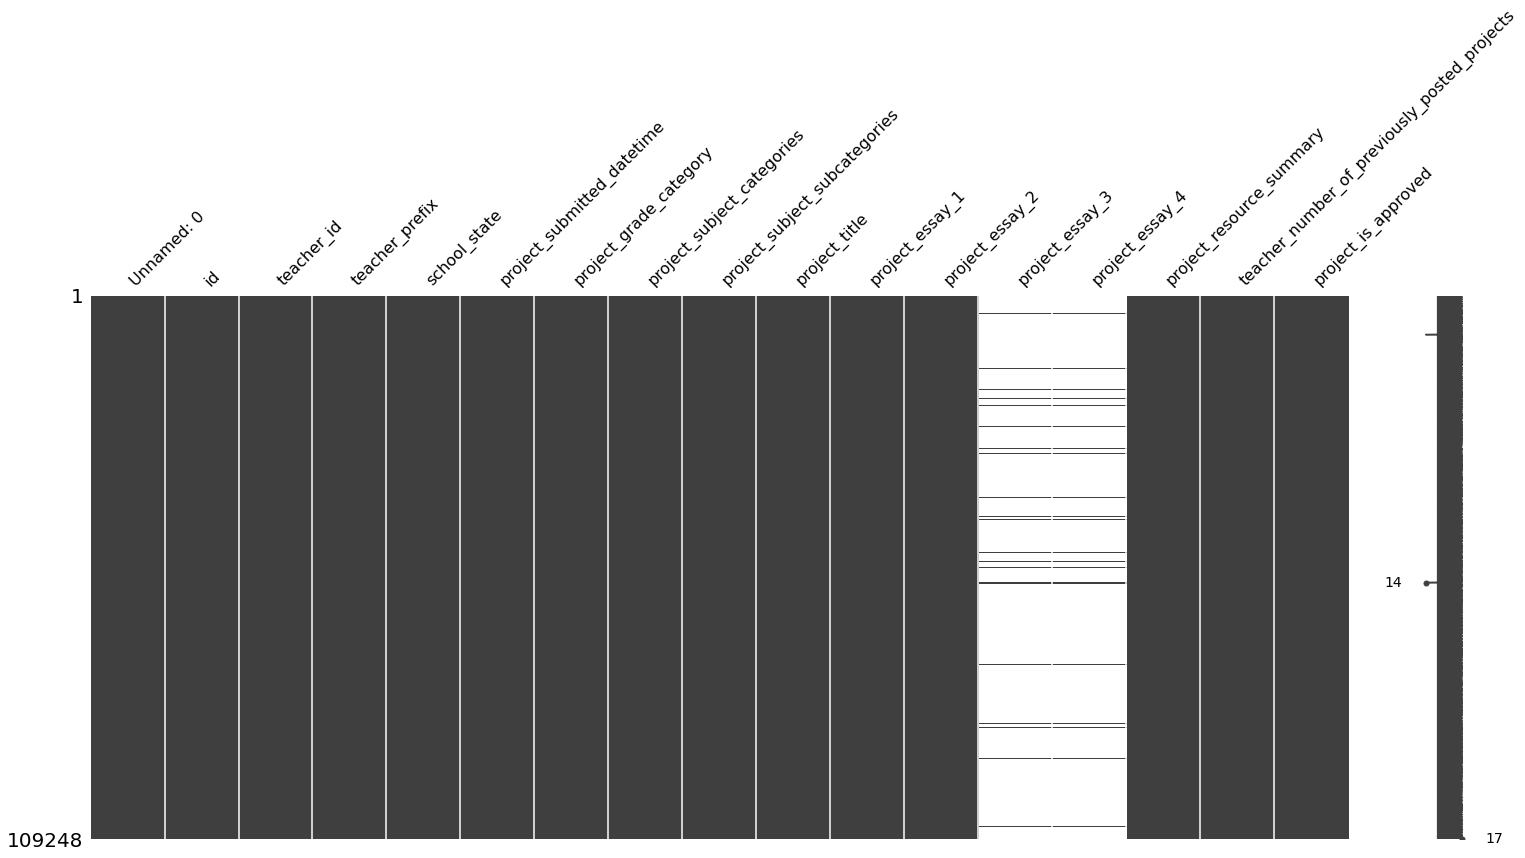

In [4]:
# https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/

msno.matrix(project_data)
plt.show()

<font color='red'>Observation</font>

- There are missing values in `teacher_prefix`, `project_essay_3` and `project_essay_4`.
- Except these 3, there are no missing values available.

In [5]:
print(f'Number of data points in train data : {resource_data.shape}')
print('Column names : \n', resource_data.columns)
resource_data.head(3)

Number of data points in train data : (1541272, 4)
Column names : 
 Index(['id', 'description', 'quantity', 'price'], dtype='object')


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


## <font color='red'>Preprocessing Categorical Features</font>

We need to remove the spaces, and special characters

- Remove additional spaces
- Remove dots : '.'
- Replace '-' with '_'
- Replace ' The ' with ''
- Replace '&' with '_'
- Replace ',' with '_'
- Convert all the characters to small case

### <font color='blue'>project_grade_category</font>

In [6]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [7]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

### <font color='blue'>project_subject_categories</font>

In [8]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

In [9]:
project_data['clean_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['clean_categories'] = project_data['clean_categories'].str.replace(' ','')
project_data['clean_categories'] = project_data['clean_categories'].str.replace('&','_')
project_data['clean_categories'] = project_data['clean_categories'].str.replace(',','_')
project_data['clean_categories'] = project_data['clean_categories'].str.lower()
project_data['clean_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

### <font color='blue'>teacher_prefix</font>

In [10]:
project_data['teacher_prefix'].isnull().sum()

3

In [11]:
project_data['teacher_prefix'].fillna('Mrs.', inplace = True)
project_data['teacher_prefix'].isnull().sum()

0

In [12]:
project_data['teacher_prefix'].value_counts()

Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [13]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

### <font color='blue'>project_subject_subcategories</font>

In [14]:
project_data['project_subject_subcategories'].value_counts()

Literacy                             9486
Literacy, Mathematics                8325
Literature & Writing, Mathematics    5923
Literacy, Literature & Writing       5571
Mathematics                          5379
                                     ... 
Community Service, Gym & Fitness        1
Parent Involvement, Team Sports         1
Gym & Fitness, Social Sciences          1
Community Service, Music                1
Economics, Foreign Languages            1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [15]:
project_data['clean_subcategories'] = \
                                project_data['project_subject_subcategories'].str.replace(' The ','')

project_data['clean_subcategories'] = \
                                project_data['clean_subcategories'].str.replace(' ','')

project_data['clean_subcategories'] = \
                                project_data['clean_subcategories'].str.replace('&','_')

project_data['clean_subcategories'] = \
                                project_data['clean_subcategories'].str.replace(',','_')

project_data['clean_subcategories'] = \
                                project_data['clean_subcategories'].str.lower()

project_data['clean_subcategories'].value_counts()

literacy                          9486
literacy_mathematics              8325
literature_writing_mathematics    5923
literacy_literature_writing       5571
mathematics                       5379
                                  ... 
communityservice_gym_fitness         1
parentinvolvement_teamsports         1
gym_fitness_socialsciences           1
communityservice_music               1
economics_foreignlanguages           1
Name: clean_subcategories, Length: 401, dtype: int64

### <font color='blue'>school_state</font>

In [16]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

In [17]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].unique()

array(['in', 'fl', 'az', 'ky', 'tx', 'ct', 'ga', 'sc', 'nc', 'ca', 'ny',
       'ok', 'ma', 'nv', 'oh', 'pa', 'al', 'la', 'va', 'ar', 'wa', 'wv',
       'id', 'tn', 'ms', 'co', 'ut', 'il', 'mi', 'hi', 'ia', 'ri', 'nj',
       'mo', 'de', 'mn', 'me', 'wy', 'nd', 'or', 'ak', 'md', 'wi', 'sd',
       'ne', 'nm', 'dc', 'ks', 'mt', 'nh', 'vt'], dtype=object)

### <font color='blue'>project_title</font>

In [18]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [19]:
# https://gist.github.com/sebleier/554280
# Removing the words from the stop words list: 'no', 'nor', 'not'

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
            'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they',
            'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
            "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
            'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
            'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
            'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
            'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
            'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
            't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm',
            'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
            'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
            'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
            'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
            "wouldn't"]

In [20]:
print('Random Review Texts')
print('=' *19)
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

Random Review Texts
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [21]:
# https://gist.github.com/sebleier/554280
# Combining all the above stundents 

def preprocess_title(text_data):
    
    preprocessed_text = []
    
    for sentance in tqdm(text_data):
        
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        
#         sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        
        preprocessed_text.append(sent.lower().strip())
        
    return preprocessed_text

In [22]:
preprocessed_titles = preprocess_title(project_data['project_title'].values)

  0%|          | 0/109248 [00:00<?, ?it/s]

In [23]:
print('BEFORE Processing')
print('=' *19)
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

print('\nAFTER Processing')
print('=' *16)
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

BEFORE Processing
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!

AFTER Processing
9 just for the love of reading pure pleasure
34 have a ball
147 who needs a chromebook we do


### <font color ='blue'>title_word_count</font>
* Adding a new feature

In [24]:
title_word_count = []
for title in tqdm(preprocessed_titles):
    title_length = len(title.split())
    title_word_count.append(title_length)
    
print(f'Length of `title_word_count` list : {len(title_word_count)}')

  0%|          | 0/109248 [00:00<?, ?it/s]

Length of `title_word_count` list : 109248


### <font color='blue'>essay</font>

In [25]:
# https://gist.github.com/sebleier/554280
# Combining all the above stundents 

def preprocess_text(text_data):
    
    preprocessed_text = []
    
    for sentance in tqdm(text_data):
        
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        
        preprocessed_text.append(sent.lower().strip())
        
    return preprocessed_text

In [26]:
# merge two column text dataframe:

project_data['essay'] = project_data['project_essay_1'].map(str) +\
                        project_data['project_essay_2'].map(str) + \
                        project_data['project_essay_3'].map(str) + \
                        project_data['project_essay_4'].map(str)

In [27]:
print('Random Essay Texts')
print('=' * 18)
print(9, project_data['essay'].values[9])
print('-' * 110)
print(34, project_data['essay'].values[34])
print('-' * 110)
print(147, project_data['essay'].values[147])

Random Essay Texts
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my students t

In [28]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

  0%|          | 0/109248 [00:00<?, ?it/s]

In [29]:
print('9 : BEFORE Processing')
print('=' * 21)
print(project_data['essay'].values[9])
print('\nAFTER Processing')
print('=' *16)
print(preprocessed_essays[9])

print('\n','-' * 110)

print('\n 34 : BEFORE Processing')
print('=' * 23)
print(project_data['essay'].values[34])
print('\nAFTER Processing')
print('=' *16)
print(preprocessed_essays[34])

print('\n','-' * 110)

print('\n147 : BEFORE Processing')
print('=' *23)
print(project_data['essay'].values[147])
print('\nAFTER Processing')
print('=' *16)
print(preprocessed_essays[147])

9 : BEFORE Processing
Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my students 

In [30]:
preprocessed_project_resource_summary = preprocess_text(project_data['project_resource_summary'].values)

  0%|          | 0/109248 [00:00<?, ?it/s]

In [31]:
print('9 : BEFORE Processing')
print('=' * 21)
print(project_data['project_resource_summary'].values[9])
print('\nAFTER Processing')
print('=' *16)
print(preprocessed_project_resource_summary[9])

print('\n','-' * 110)

print('\n34 : BEFORE Processing')
print('=' * 22)
print(project_data['project_resource_summary'].values[34])
print('\nAFTER Processing')
print('=' *16)
print(preprocessed_project_resource_summary[34])

print('\n','-' * 110)

print('\n147 : BEFORE Processing')
print('=' *23)
print(project_data['project_resource_summary'].values[147])
print('\nAFTER Processing')
print('=' *16)
print(preprocessed_project_resource_summary[147])

9 : BEFORE Processing
My students need great books to use during Independent Reading, Read Alouds, Partner Reading and Author Studies.

AFTER Processing
students need great books use independent reading read alouds partner reading author studies

 --------------------------------------------------------------------------------------------------------------

34 : BEFORE Processing
My students need alternative seating, to increase student choice, and add to mobility in the classroom.

AFTER Processing
students need alternative seating increase student choice add mobility classroom

 --------------------------------------------------------------------------------------------------------------

147 : BEFORE Processing
My students need a chromebook to help with differentiation and extra practice!!!

AFTER Processing
students need chromebook help differentiation extra practice


## <font color='red'>Preprocessing Categorical Features</font>
### <font color='blue'>price_data</font>

In [32]:
'''
https://stackoverflow.com/questions/22407798/how-to-reset-a-
dataframes-indexes-for-all-groups-in-one-step
'''

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(3)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4


In [33]:
# Joining two dataframes `project_data` & `price_data` : 

project_data = pd.merge(project_data, price_data, on='id', how='left')

In [34]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

In [35]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,...,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,...,NaN,NaN,My students need opportunities to practice beg...,0,0,literacy_language,esl_literacy,My students are English learners that are work...,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,...,NaN,NaN,My students need a projector to help with view...,7,1,history_civics_health_sports,civics_government_teamsports,Our students arrive to our school eager to lea...,299.0,1


**<font color='red'>Appending new features to `project_data`</font>**

In [36]:
project_data['clean_essay'] = preprocessed_essays
project_data['clean_project_title'] = preprocessed_titles
project_data['clean_project_resource_summary'] = preprocessed_project_resource_summary
project_data['title_word_count'] = title_word_count

project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 26 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    109248 non-null  int64  
 1   id                                            109248 non-null  object 
 2   teacher_id                                    109248 non-null  object 
 3   teacher_prefix                                109248 non-null  object 
 4   school_state                                  109248 non-null  object 
 5   project_submitted_datetime                    109248 non-null  object 
 6   project_grade_category                        109248 non-null  object 
 7   project_subject_categories                    109248 non-null  object 
 8   project_subject_subcategories                 109248 non-null  object 
 9   project_title                                 10

#### <font color='red'>Removing processed columns and saving the dataframe into</font> `processed_data.csv`

In [37]:
drop_c = ['project_subject_categories', 'project_subject_subcategories', 'project_title', 
         'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'essay',
         'Unnamed: 0', 'teacher_id', 'project_submitted_datetime', 'project_resource_summary', 'id']

final_project_data = project_data.drop(drop_c, axis=1)

final_project_data.to_csv('processed_data.csv', index=False)

time_processing = time.time()

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='http://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='http://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='http://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='http://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [38]:
sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)

# sample_sentence_1 = 'I am going to New Delhi tommorow.'
# neg = sid.polarity_scores(sample_sentence_1)['neg']
# neu = sid.polarity_scores(sample_sentence_1)['neu']
# pos = sid.polarity_scores(sample_sentence_1)['pos']
# comp = sid.polarity_scores(sample_sentence_1)['compound']

# print(f"'neg': {neg}, 'neu': {neu}, 'pos': {pos}, 'compound': {comp}")

sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [39]:
data = pd.read_csv('processed_data.csv', nrows = 36000)

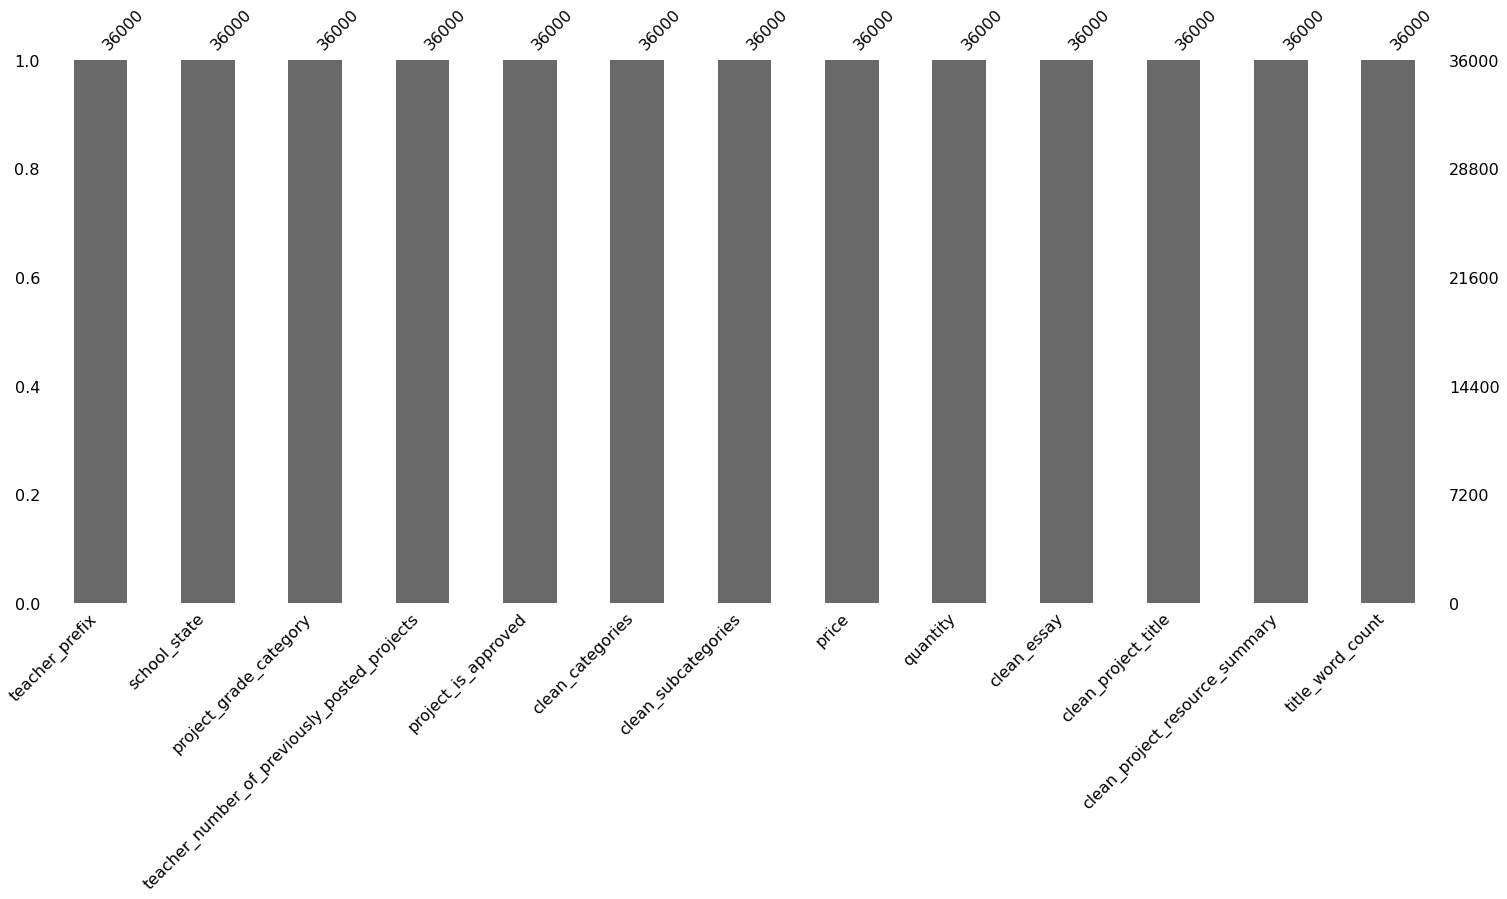

In [40]:
msno.bar(data)
plt.show()

**<font color='red'>Observation</font>**

- It is clearly visible that we don't have any missing values in the data frame.
- We have 36,000 (36K) data points and 13 features (columns)

In [41]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [42]:
print(f'Number of data points in train data : {data.shape}')
print('\nColumn names : \n', data.columns)

Number of data points in train data : (36000, 13)

Column names : 
 Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'price', 'quantity',
       'clean_essay', 'clean_project_title', 'clean_project_resource_summary',
       'title_word_count'],
      dtype='object')


In [43]:
data.head(3)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,clean_essay,clean_project_title,clean_project_resource_summary,title_word_count
0,mrs,in,grades_prek_2,0,0,literacy_language,esl_literacy,154.60,23,students english learners working english seco...,educational support for english learners at home,students need opportunities practice beginning...,7
1,mr,fl,grades_6_8,7,1,history_civics_health_sports,civics_government_teamsports,299.00,1,students arrive school eager learn polite gene...,wanted projector for hungry learners,students need projector help viewing education...,5
2,ms,az,grades_6_8,1,0,health_sports,health_wellness_teamsports,516.85,22,true champions not always ones win guts mia ha...,soccer equipment for awesome middle school stu...,students need shine guards athletic socks socc...,7


In [44]:
# Generating sentiment scores using NLTK SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

negative = []
neutral  = []
positive = []
compound = []

print('Shape before adding Sentiment Scores : ', data.shape)

for a in tqdm(data['clean_essay']) :
    neg = sid.polarity_scores(a)['neg']
    neu = sid.polarity_scores(a)['neu']
    pos = sid.polarity_scores(a)['pos']
    comp = sid.polarity_scores(a)['compound']

    negative.append(neg)
    neutral.append(neu)
    positive.append(pos)
    compound.append(comp)

data['negative'] = negative
data['positive'] = positive
data['neutral'] = neutral
data['compound'] = compound

print('Shape after adding Sentiment Scores : ', data.shape)

Shape before adding Sentiment Scores :  (36000, 13)


  0%|          | 0/36000 [00:00<?, ?it/s]

Shape after adding Sentiment Scores :  (36000, 17)


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [45]:
data.head(3)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,clean_essay,clean_project_title,clean_project_resource_summary,title_word_count,negative,positive,neutral,compound
0,mrs,in,grades_prek_2,0,0,literacy_language,esl_literacy,154.60,23,students english learners working english seco...,educational support for english learners at home,students need opportunities practice beginning...,7,0.013,0.154,0.833,0.9694
1,mr,fl,grades_6_8,7,1,history_civics_health_sports,civics_government_teamsports,299.00,1,students arrive school eager learn polite gene...,wanted projector for hungry learners,students need projector help viewing education...,5,0.052,0.305,0.643,0.9856
2,ms,az,grades_6_8,1,0,health_sports,health_wellness_teamsports,516.85,22,true champions not always ones win guts mia ha...,soccer equipment for awesome middle school stu...,students need shine guards athletic socks socc...,7,0.128,0.230,0.643,0.9816


### <font color='red'>Exploring Data</font>
**<font color='blue'>`quantity` column</font>**

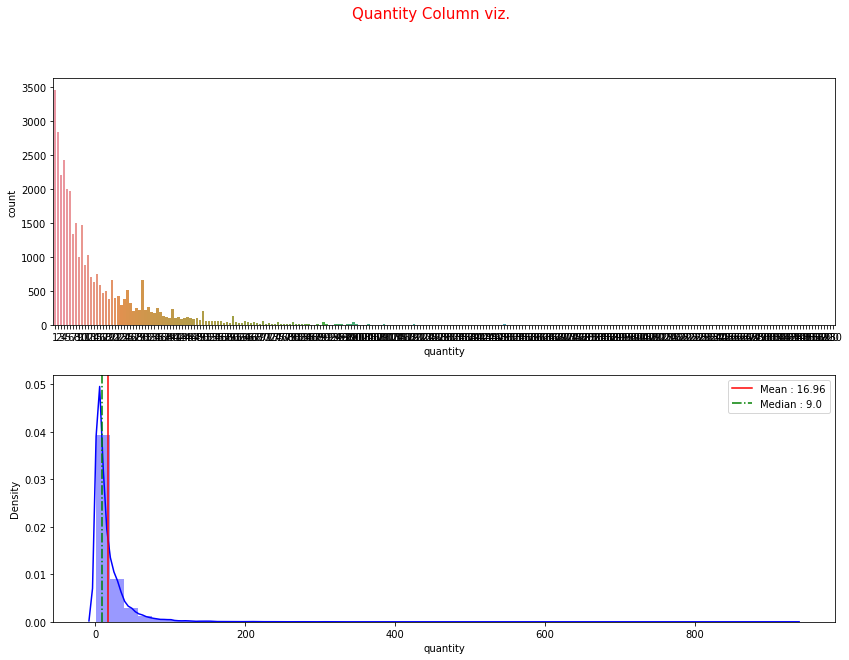

In [46]:
mean_q = round(data.quantity.mean(), 2)
median_q = round(data.quantity.median(), 2)

fig, axes = plt.subplots(2, 1, figsize = (14,10))

fig.suptitle('Quantity Column viz.', fontsize = 15, color = 'r')
fig_1 = sns.countplot(data.quantity, ax = axes[0])

fig_2 = sns.distplot(data.quantity, color = 'b', ax = axes[1])
plt.axvline(mean_q, c = 'r', label = f'Mean : {mean_q}')
plt.axvline(median_q, c = 'g', linestyle = '-.', label = f'Median : {median_q}')

plt.legend()
plt.show()

<font color='red'>Observation</font>

- Its clearly visible the `quantity` column is **Right Skewed**.

- Majority of the data points lies within `mean score 16`.
- Most frequent quantity requested by teachers is **10**.

**<font color='blue'>`title_word_count` column</font>**

In [47]:
data.title_word_count.value_counts(ascending = True)

14       1
15       1
13       8
1       10
12      44
11     236
10    1304
9     1843
8     2471
2     2665
7     3728
6     5064
3     5742
5     6396
4     6487
Name: title_word_count, dtype: int64

title_word_count  :::  Mean = 5.27  &  Median = 5.0


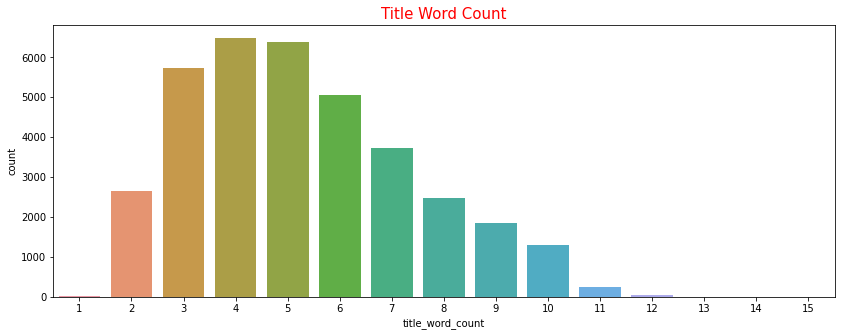

In [48]:
mean_twc = round(data.title_word_count.mean(), 2)
median_twc = round(data.title_word_count.median(), 2)

plt.figure(figsize = (14,5))

fig = sns.countplot(data.title_word_count)
plt.title('Title Word Count', fontsize = 15, color = 'r')

print(f'title_word_count  :::  Mean = {mean_twc}  &  Median = {median_twc}')

plt.show()

<font color='red'>Observation</font>

- Majority of the projects contains 2 to 8 words (after preprocessing).
- Projects with 4 & 5 words are those mostly submitted.
- The `median` and `mean` value lies in close to **5** words.
- 65% of the projects contains 3 to 6 words in its title

**<font color = 'red'>Converting into `train_test_split`</font>**

In [49]:
y_data = data['project_is_approved'].values
# x_data = data.drop(['project_is_approved'], axis =1)
x_train, x_test, y_train, y_test = train_test_split(data, y_data, test_size = 0.3 ,stratify = y_data)

x_train.head(3)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,clean_essay,clean_project_title,clean_project_resource_summary,title_word_count,negative,positive,neutral,compound
2023,mrs,tx,grades_3_5,0,0,math_science,environmentalscience_mathematics,386.97,5,students unique bunch sweethearts love sometim...,5th grade math lovers,students need hands math manipulatives help co...,4,0.017,0.417,0.567,0.9963
10858,ms,ca,grades_3_5,9,1,appliedlearning_literacy_language,college_careerprep_literature_writing,392.44,3,students group hardworking individuals strive ...,let is show off to the community in color,students need color printer copier showcase pr...,9,0.102,0.279,0.619,0.9770
26788,ms,al,grades_prek_2,16,1,health_sports,gym_fitness_health_wellness,107.03,3,teach kindergarten fifteen wonderful students ...,listen dance laugh,students need songs dance dvds indoor recess s...,3,0.000,0.358,0.642,0.9947


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### <font color = 'blue'>clean_project_title</font>
**<font color = 'red'>TF-IDF</font>**

In [50]:
tfidf_vectorizor = TfidfVectorizer(min_df = 5, ngram_range = (1,3), max_features = 10000)
tfidf_vectorizor.fit(x_train['clean_project_title'].values)
x_tr_title_tfidf = tfidf_vectorizor.transform(x_train['clean_project_title'].values)
x_te_title_tfidf = tfidf_vectorizor.transform(x_test['clean_project_title'].values)

print(f"Shape of matrix before TF-IDF Vectorizor : {x_train.shape}  {x_test.shape}")
print(f"Shape of matrix after TF-IDF Vectorizor  : {x_tr_title_tfidf.shape} {x_te_title_tfidf.shape}")

Shape of matrix before TF-IDF Vectorizor : (25200, 17)  (10800, 17)
Shape of matrix after TF-IDF Vectorizor  : (25200, 6398) (10800, 6398)


**<font color = 'red'>TF-IDF W2V</font>**

In [51]:
# Converting a dictionary with word as a key, and the idf as a value

dictionary = dict(zip(tfidf_vectorizor.get_feature_names(), list(tfidf_vectorizor.idf_)))
tfidf_words = set(tfidf_vectorizor.get_feature_names())

tfidf_w2v_title_x_tr = []

# clean_project_title

for sentence in tqdm(x_train['clean_project_title']):
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0
    
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
            
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        
    tfidf_w2v_title_x_tr.append(vector)
    
print(f'x_train TF-IDF-W2V shape is {len(tfidf_w2v_title_x_tr) , len(tfidf_w2v_title_x_tr[0])}')

tfidf_w2v_title_x_te = []

for sentence in tqdm(x_test['clean_project_title']):
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0
    
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
            
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        
    tfidf_w2v_title_x_te.append(vector)

print(f'x_test TF-IDF-W2V shape is {len(tfidf_w2v_title_x_te) , len(tfidf_w2v_title_x_te[0])}')

  0%|          | 0/25200 [00:00<?, ?it/s]

x_train TF-IDF-W2V shape is (25200, 300)


  0%|          | 0/10800 [00:00<?, ?it/s]

x_test TF-IDF-W2V shape is (10800, 300)


### <font color = 'blue'>clean_essay</font>
**<font color = 'red'>TF-IDF</font>**

In [52]:
tfidf_vectorizor = TfidfVectorizer(min_df = 20, ngram_range = (1,3), max_features = 15000)
tfidf_vectorizor.fit(x_train['clean_essay'].values)
x_tr_essay_tfidf = tfidf_vectorizor.transform(x_train['clean_essay'].values)
x_te_essay_tfidf = tfidf_vectorizor.transform(x_test['clean_essay'].values)

print(f"Shape of matrix before TF-IDF Vectorizor : {x_train.shape}   {x_test.shape}")
print(f"Shape of matrix after TF-IDF Vectorizor  : {x_tr_essay_tfidf.shape} {x_te_essay_tfidf.shape}")

Shape of matrix before TF-IDF Vectorizor : (25200, 17)   (10800, 17)
Shape of matrix after TF-IDF Vectorizor  : (25200, 15000) (10800, 15000)


**<font color = 'red'>TF-IDF W2V</font>**

In [53]:
# Converting a dictionary with word as a key, and the idf as a value

dictionary = dict(zip(tfidf_vectorizor.get_feature_names(), list(tfidf_vectorizor.idf_)))
tfidf_words = set(tfidf_vectorizor.get_feature_names())

tfidf_w2v_essay_x_tr = []

for sentence in tqdm(x_train['clean_essay']):
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0
    
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
            
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        
    tfidf_w2v_essay_x_tr.append(vector)
    
print(f'x_train TF-IDF-W2V shape is {len(tfidf_w2v_essay_x_tr) , len(tfidf_w2v_essay_x_tr[0])}')

tfidf_w2v_essay_x_te = []

for sentence in tqdm(x_test['clean_essay']):
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0
    
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
            
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        
    tfidf_w2v_essay_x_te.append(vector)

print(f'x_test TF-IDF-W2V shape is {len(tfidf_w2v_essay_x_te) , len(tfidf_w2v_essay_x_te[0])}')

  0%|          | 0/25200 [00:00<?, ?it/s]

x_train TF-IDF-W2V shape is (25200, 300)


  0%|          | 0/10800 [00:00<?, ?it/s]

x_test TF-IDF-W2V shape is (10800, 300)


**<font color = 'blue'>TF-IDF : clean_project_resource_summary</font>**

In [54]:
tfidf_vectorizor = TfidfVectorizer(min_df = 10, ngram_range = (1,3), max_features = 10000)
tfidf_vectorizor.fit(x_train['clean_project_resource_summary'].values)
x_tr_rs_sum_tfidf = tfidf_vectorizor.transform(x_train['clean_project_resource_summary'].values)
x_te_rs_sum_tfidf = tfidf_vectorizor.transform(x_test['clean_project_resource_summary'].values)

print(f"Shape of matrix before TF-IDF Vectorizor : {x_train.shape}  {x_test.shape}")
print(f"Shape of matrix after TF-IDF Vectorizor  : {x_tr_rs_sum_tfidf.shape} {x_te_rs_sum_tfidf.shape}")

Shape of matrix before TF-IDF Vectorizor : (25200, 17)  (10800, 17)
Shape of matrix after TF-IDF Vectorizor  : (25200, 6609) (10800, 6609)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### <font color = 'blue'>Processing Numerical features</font>

In [55]:
print('Shape of matrix after encodig :')
print('(Numerical features)')
print('='*40)

# price
price_normalizer = Normalizer()
price_normalizer.fit(x_train['price'].values.reshape(-1, 1))

x_train_price = price_normalizer.transform(x_train['price'].values.reshape(-1, 1))
x_test_price = price_normalizer.transform(x_test['price'].values.reshape(-1, 1))

print('Price\t\t\t: ', x_train_price.shape,',',x_test_price.shape)

# quantity
quantity_normalizer = Normalizer()
quantity_normalizer.fit(x_train['quantity'].values.reshape(-1, 1))

x_train_quantity = quantity_normalizer.transform(x_train['quantity'].values.reshape(-1, 1))
x_test_quantity = quantity_normalizer.transform(x_test['quantity'].values.reshape(-1, 1))

print('Quantity\t\t: ', x_train_quantity.shape,',',x_test_quantity.shape)


# teacher_number_of_previously_posted_projects
pervious_project_normalizer = Normalizer()
pervious_project_normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].\
                                                values.reshape(-1, 1))
x_train_previous_projects = pervious_project_normalizer.transform(
                x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

x_test_previous_projects = pervious_project_normalizer.transform(
                x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

print('Previous Projects\t: ', x_train_previous_projects.shape,',',x_test_previous_projects.shape)

# negative
negative_normalizer = Normalizer()
negative_normalizer.fit(x_train['negative'].values.reshape(-1, 1))

x_train_negative = negative_normalizer.transform(x_train['negative'].values.reshape(-1, 1))
x_test_negative = negative_normalizer.transform(x_test['negative'].values.reshape(-1, 1))

print('Negative\t\t: ', x_train_negative.shape,',',x_test_negative.shape)

# positive
positive_normalizer = Normalizer()
positive_normalizer.fit(x_train['positive'].values.reshape(-1, 1))

x_train_positive = positive_normalizer.transform(x_train['positive'].values.reshape(-1, 1))
x_test_positive = positive_normalizer.transform(x_test['positive'].values.reshape(-1, 1))

print('Positive\t\t: ', x_train_positive.shape,',',x_test_positive.shape)

# neutral
neutral_normalizer = Normalizer()
neutral_normalizer.fit(x_train['neutral'].values.reshape(-1, 1))

x_train_neutral = neutral_normalizer.transform(x_train['neutral'].values.reshape(-1, 1))
x_test_neutral = neutral_normalizer.transform(x_test['neutral'].values.reshape(-1, 1))

print('Neutral\t\t\t: ', x_train_neutral.shape,',',x_test_neutral.shape)

# compound
compound_normalizer = Normalizer()
compound_normalizer.fit(x_train['compound'].values.reshape(-1, 1))

x_train_compound = compound_normalizer.transform(x_train['compound'].values.reshape(-1, 1))
x_test_compound = compound_normalizer.transform(x_test['compound'].values.reshape(-1, 1))

print('Compound\t\t: ', x_train_compound.shape,',',x_test_compound.shape)

# title_word_count
title_count_normalizer = Normalizer()
title_count_normalizer.fit(x_train['title_word_count'].values.reshape(-1, 1))

x_train_title_count = title_count_normalizer.transform(x_train['title_word_count'].values.reshape(-1, 1))
x_test_title_count = title_count_normalizer.transform(x_test['title_word_count'].values.reshape(-1, 1))

print('Title Word Count\t: ', x_train_title_count.shape,',',x_test_title_count.shape)

Shape of matrix after encodig :
(Numerical features)
Price			:  (25200, 1) , (10800, 1)
Quantity		:  (25200, 1) , (10800, 1)
Previous Projects	:  (25200, 1) , (10800, 1)
Negative		:  (25200, 1) , (10800, 1)
Positive		:  (25200, 1) , (10800, 1)
Neutral			:  (25200, 1) , (10800, 1)
Compound		:  (25200, 1) , (10800, 1)
Title Word Count	:  (25200, 1) , (10800, 1)


### <font color = 'blue'>Response coding on categorical features</font>

In [56]:
columns_ = ['school_state', 'project_is_approved']

data.loc[(data.school_state == 'ia')][columns_]

print(len(data.loc[(data.school_state == 'co') & (data.project_is_approved == 1)][columns_]))
print(len(data.loc[(data.school_state == 'co') & (data.project_is_approved == 0)][columns_]))
data.loc[(data.school_state == 'co') & (data.project_is_approved == 1)][columns_]

309
61


,school_state,project_is_approved
83,co,1
150,co,1
233,co,1
321,co,1
370,co,1
...,...,...
35444,co,1
35801,co,1
35816,co,1
35837,co,1


In [57]:
'''
https://www.delftstack.com/howto/python-pandas/pandas-replace-values-in-column/#replace
-column-values-with-collection-in-pandas-dataframe
'''

def responseEncoding(df, column):
    
    cat_feature = df[column].unique()
    length_of_cat = len(cat_feature)
    
    positive_class = []
    for cat in tqdm(cat_feature):
        positive_class.append(len(df.loc[(df[column] == cat) & (df.project_is_approved == 1)]))
        
    negative_class = []
    for cat in cat_feature:
        negative_class.append(len(df.loc[(df[column] == cat) & (df.project_is_approved == 0)]))
        
    positive_val = []
    for i in range(len(cat_feature)):
        positive_val.append(positive_class[i] / (positive_class[i] + negative_class[i]))
    
    negative_val = [1-i for i in positive_val]
    
    positives = dict(zip(cat_feature, positive_val))
    
    negatives = dict(zip(cat_feature, negative_val))
    
    return positives, negatives
        
# responseEncoding(data,'school_state') 

In [58]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
'''
https://www.delftstack.com/howto/python-pandas/pandas-replace-values-in-column/#replace
-column-values-with-collection-in-pandas-dataframe
'''
    
def render_DataFrame(train, test):
    
#     cat_list = ['school_state', 'teacher_prefix', 'project_grade_category',
#                 'clean_categories', 'clean_subcategories', 'project_is_approved']

    to_rc_list = ['school_state', 'teacher_prefix', 'project_grade_category',
                 'clean_categories', 'clean_subcategories']
    
    rc_list = ['school_state_0', 'school_state_1', 'teacher_prefix_0', 'teacher_prefix_1',
              'project_grade_category_0', 'project_grade_category_1',
              'clean_categories_0', 'clean_categories_1',
              'clean_subcategories_0', 'clean_subcategories_1']
    
    pos_state, neg_state = responseEncoding(train, 'school_state')
    pos_teacher, neg_teacher = responseEncoding(train, 'teacher_prefix')
    pos_proj_g, neg_proj_g = responseEncoding(train, 'project_grade_category')
    pos_clean_cat, neg_clean_cat = responseEncoding(train, 'clean_categories')
    pos_clean_sub, neg_clean_sub = responseEncoding(train, 'clean_subcategories')
    
#     On Train Data
    train['school_state_0'] = train.school_state.map(neg_state) #negative
    train['school_state_1'] = train.school_state.map(pos_state) #positive
    
    train['teacher_prefix_0'] = train.teacher_prefix.map(neg_teacher)
    train['teacher_prefix_1'] = train.teacher_prefix.map(pos_teacher)

    train['project_grade_category_0'] = train.project_grade_category.map(neg_proj_g)
    train['project_grade_category_1'] = train.project_grade_category.map(pos_proj_g)
    
    train['clean_categories_0'] = train.clean_categories.map(neg_clean_cat)
    train['clean_categories_1'] = train.clean_categories.map(pos_clean_cat)
    
    train['clean_subcategories_0'] = train.clean_subcategories.map(neg_clean_sub)
    train['clean_subcategories_1'] = train.clean_subcategories.map(pos_clean_sub)
    
    rc_train = pd.DataFrame()
    rc_train = train[rc_list]
    
#     On Test Data
    test['school_state_0'] = test.school_state.map(neg_state) #negative
    test['school_state_1'] = test.school_state.map(pos_state) #positive
    
    test['teacher_prefix_0'] = test.teacher_prefix.map(neg_teacher)
    test['teacher_prefix_1'] = test.teacher_prefix.map(pos_teacher)

    test['project_grade_category_0'] = test.project_grade_category.map(neg_proj_g)
    test['project_grade_category_1'] = test.project_grade_category.map(pos_proj_g)
    
    test['clean_categories_0'] = test.clean_categories.map(neg_clean_cat)
    test['clean_categories_1'] = test.clean_categories.map(pos_clean_cat)
    
    test['clean_subcategories_0'] = test.clean_subcategories.map(neg_clean_sub)
    test['clean_subcategories_1'] = test.clean_subcategories.map(pos_clean_sub)    
    
    '''
    Applying laplase smoothing value for test set
    ---------------------------------------------
    
    If test point is present in test but not in train, then applying 0.5 as default
    probability value for that data point
    '''
    
    rc_test  = pd.DataFrame()
    rc_test = test[rc_list].fillna(0.5)
    
    return to_rc_list, rc_train, rc_test

rc_cat_list, rc_X_train, rc_X_test = render_DataFrame(x_train, x_test)

print('Response coded categories are :\n', ', '.join(rc_cat_list))

print(f'\nResponse coded x_train shape : {rc_X_train.shape}')
print(f'Response coded x_test shape  : {rc_X_test.shape}')

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Response coded categories are :
 school_state, teacher_prefix, project_grade_category, clean_categories, clean_subcategories

Response coded x_train shape : (25200, 10)
Response coded x_test shape  : (10800, 10)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## <font color = 'red'>Set 1</font>
categorical(instead of one hot encoding, try response coding: use probability values, numerical features + project_title(TFIDF+ preprocessed_eassay (TFIDF + sentiment Score of eassay(check the bellow example, include all 4 values as 4 features

In [59]:
# https://stackoverflow.com/a/65470570
# https://stackoverflow.com/a/19710648/4084039

tfidf_stack_train = hstack((rc_X_train, x_train_price, x_train_quantity, x_train_previous_projects,
                            x_train_title_count, x_tr_title_tfidf, x_tr_essay_tfidf,
                            x_tr_rs_sum_tfidf, x_train_negative, x_train_positive, x_train_neutral,
                            x_train_compound)).tocsr()

tfidf_stack_test = hstack((rc_X_test, x_test_price, x_test_quantity, x_test_previous_projects,
                           x_test_title_count, x_te_title_tfidf, x_te_essay_tfidf,
                           x_te_rs_sum_tfidf, x_test_negative, x_test_positive, x_test_neutral,
                           x_test_compound)).tocsr()

print('TFIDF stack train shape\t: ', tfidf_stack_train.shape)
print('TFIDF stack test shape\t: ', tfidf_stack_test.shape)

TFIDF stack train shape	:  (25200, 28025)
TFIDF stack test shape	:  (10800, 28025)


### <font color = 'blue'>Hyperparameter Tuning</font>

In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# learning_rate values taken from
# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
# https://stackoverflow.com/a/58782583
# https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search

gbdt = GradientBoostingClassifier()

parameters= {'max_depth' : [2, 3, 5, 7, 8, 10],
             'n_estimators' : [10, 25, 65, 125, 250, 500],
             'learning_rate' : [0.001, 0.03, 0.075, 0.1, 0.2, 0.3]}

clf = RandomizedSearchCV(gbdt, parameters, cv = 5, scoring = 'roc_auc', 
                         return_train_score = True, n_jobs =-1)

r_search = clf.fit(tfidf_stack_train, y_train)
best_params_tfidf = r_search.best_params_

print(f'Best parameters fron TF-IDF model : \n{best_params_tfidf}')

tfidf_n_estimators = best_params_tfidf['n_estimators']
tfidf_max_depth = best_params_tfidf['max_depth']
tfidf_learning_rate = best_params_tfidf['learning_rate']

data = {'param_n_estimators' : r_search.cv_results_['param_n_estimators'],
        'param_max_depth' : r_search.cv_results_['param_max_depth'],
        'param_learning_rate' : r_search.cv_results_['param_learning_rate'],
        'mean_train_score' : r_search.cv_results_['mean_train_score'],
        'mean_test_score' : r_search.cv_results_['mean_test_score']
       }

performance_tfidf = pd.DataFrame(data)
# performance_tfidf.head()

Best parameters fron TF-IDF model : 
{'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.1}


In [61]:
group_perf_tfidf = performance_tfidf[['param_n_estimators', 'param_max_depth', 'mean_train_score',
                'mean_test_score']].groupby(['param_n_estimators', 'param_max_depth']).max().unstack()
group_perf_tfidf

mean_train_score                                         \
param_max_depth                  2        3         5         7         8    
param_n_estimators                                                           
10                              NaN      NaN       NaN  0.805868  0.829361   
25                              NaN      NaN       NaN  0.680095       NaN   
65                              NaN      NaN       NaN       NaN       NaN   
125                             NaN  0.87182  0.675466       NaN       NaN   
250                        0.878311      NaN       NaN  0.998399       NaN   

                             mean_test_score                                \
param_max_depth           10              2         3         5         7    
param_n_estimators                                                           
10                       NaN             NaN       NaN       NaN  0.668204   
25                       NaN             NaN       NaN       NaN  0.633756   
65                  0.990619             NaN       NaN       NaN       NaN   
125                 0.995830             NaN  0.683397  0.643467       NaN   
250                      NaN        0.683239       NaN       NaN  0.684024   

                                        
param_max_depth           8         10  
param_n_estimators                      
10                  0.666745       NaN  
25                       NaN       NaN  
65                       NaN  0.668952  
125                      NaN  0.679243  
250                      NaN       NaN

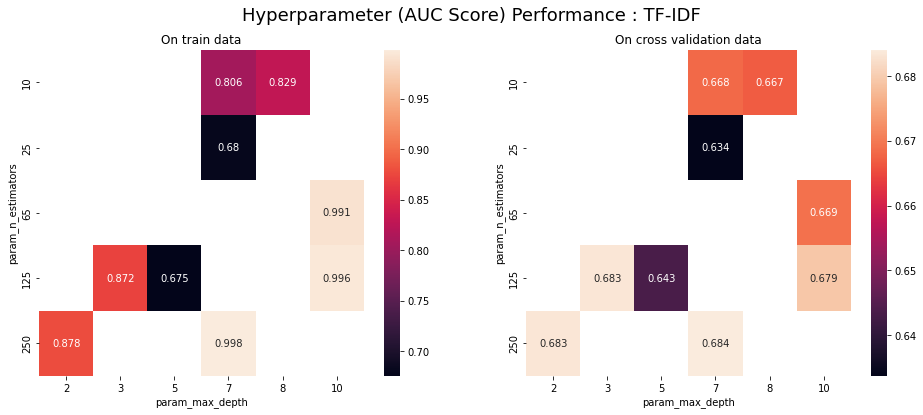

In [62]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.suptitle('Hyperparameter (AUC Score) Performance : TF-IDF', fontsize = 18)

# https://stackoverflow.com/a/39133654
    
fig_1 = sns.heatmap(group_perf_tfidf.mean_train_score, annot = True, fmt='.3g', ax = axes[0])
fig_1.title.set_text('On train data')

fig_2 = sns.heatmap(group_perf_tfidf.mean_test_score, annot = True, fmt='.3g', ax = axes[1])
fig_2.title.set_text('On cross validation data')

plt.show()

**<font color='red'>Observation</font>**

- While `n_estimators = 250` and `max_depth = 7`, we are getting an **AUC** of **0.998**.
- The next lower **AUC** is **0.996** and it is at `n_estimators = 250` and `max_depth = 7`.
- So we are taking `n_estimators = 250` and `max_depth = 7` as the best parameter.

### <font color = 'blue'>Training Using Best Hyperparameter</font>

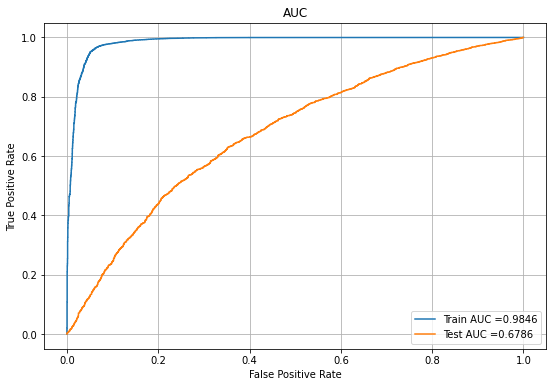

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

tfidf_gbdt = GradientBoostingClassifier(
                    n_estimators = tfidf_n_estimators, max_depth = tfidf_max_depth,
                    learning_rate = tfidf_learning_rate)

tfidf_gbdt.fit(tfidf_stack_train, y_train)

y_train_pred_tfidf = tfidf_gbdt.predict_proba(tfidf_stack_train)[:,1]
y_test_pred_tfidf = tfidf_gbdt.predict_proba(tfidf_stack_test)[:,1]

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)

auc_train_set1 = auc(train_fpr, train_tpr)
auc_test_set1 = auc(test_fpr, test_tpr)

#Reference : DonorchooseNB assignment
plt.figure(figsize = (9,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc_train_set1,4)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(round(auc_test_set1,4)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.grid()
plt.legend(loc=4)
plt.show()

### <font color = 'blue'>Train & Test Confusion Matrix</font>

In [64]:
# Reference DonorchooseNB

def best_threshold_and_y_pred(threshould, proba, fpr, tpr):
    
    best_t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", round(max(tpr*(1-fpr)),5), "for threshold", np.round(best_t,3))
   
    predictions = []
    for i in tqdm(proba):
        if i >= best_t:
            predictions.append(1)
        else:
            predictions.append(0)
    return best_t, predictions

Train
=====
The maximum value of tpr*(1-fpr) 0.90434 for threshold 0.791


  0%|          | 0/25200 [00:00<?, ?it/s]


Test
====
The maximum value of tpr*(1-fpr) 0.40755 for threshold 0.873


  0%|          | 0/10800 [00:00<?, ?it/s]


Train confusion matrix : 
 [[ 3636   243]
 [  751 20570]]

Test confusion matrix : 
 [[1074  589]
 [3371 5766]]


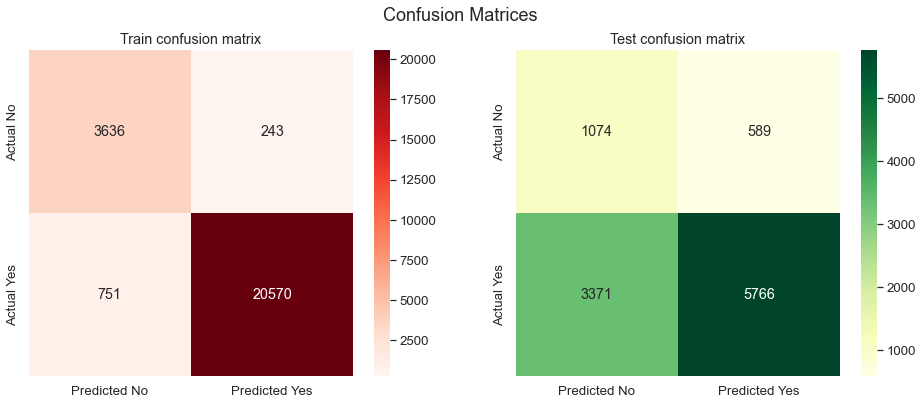

In [65]:
print('Train')
print('=' * 5)
tfidf_tr_thr, tfidf_tr_pred = best_threshold_and_y_pred(tr_thresholds,
                                                            y_train_pred_tfidf, train_fpr, train_tpr)
confusion_mat_tfidf_tr = confusion_matrix(y_train, tfidf_tr_pred)

print('\nTest')
print('=' * 4)
tfidf_te_thr, tfidf_te_pred = best_threshold_and_y_pred(te_thresholds,
                                                                y_test_pred_tfidf, test_fpr, test_tpr)
confusion_mat_tfidf_te = confusion_matrix(y_test, tfidf_te_pred)

print('\nTrain confusion matrix : \n', confusion_mat_tfidf_tr)
print('\nTest confusion matrix : \n', confusion_mat_tfidf_te)


# https://stackoverflow.com/a/61748695
# https://stackoverflow.com/a/39133654

sns.set(font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.suptitle('Confusion Matrices', fontsize = 18)

fig_1 = sns.heatmap(confusion_mat_tfidf_tr, annot=True, fmt="d", cmap='Reds', ax = axes[0])
fig_1.title.set_text('Train confusion matrix')
axes[0].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[0].set_yticklabels(['Actual No', 'Actual Yes'])

fig_2 = sns.heatmap(confusion_mat_tfidf_te, annot=True, fmt="d", cmap='YlGn', ax = axes[1])
fig_2.title.set_text('Test confusion matrix')
axes[1].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[1].set_yticklabels(['Actual No', 'Actual Yes'])

plt.show()

**<font color='red'>Observation</font>**

- Train AUC (0.9846) is higher than the Test AUC (0.6786) score.
- We can consider this as overfitting.
- We can conisder more number of points for training model to avoid overfitting.
- Ratio of `True Positive` to `total data in train data` is 81.62% and while for `test data` the same ratio is only 53.38%.
- The **False Positive** (589) on `test data` is lesser than **False Negative** (3371) value which is not good.

NB : While testing for very samll number of datapoints (1000, 2000 and 3000) the train AUC was 1.0 and Test AUC was in a range of 0.45 to 0.6. On increasing numberof datapoints model is showing a good behaviour. So training model at larger datapoints may can avoid overfitting tendency.

## <font color = 'red'>Set 2</font>
categorical(instead of one hot encoding, try response coding: use probability values, numerical features + project_title(TFIDF W2V+ preprocessed_eassay (TFIDF W2V

In [66]:
# https://stackoverflow.com/a/65470570
# https://stackoverflow.com/a/19710648/4084039

tfidf_w2v_stack_train = hstack((rc_X_train, x_train_price, x_train_quantity, x_train_previous_projects,
                            x_train_title_count, tfidf_w2v_title_x_tr, tfidf_w2v_essay_x_tr,
                            x_tr_rs_sum_tfidf, x_train_negative, x_train_positive, x_train_neutral,
                            x_train_compound)).tocsr()

tfidf_w2v_stack_test = hstack((rc_X_test, x_test_price, x_test_quantity, x_test_previous_projects,
                           x_test_title_count, tfidf_w2v_title_x_te, tfidf_w2v_essay_x_te,
                           x_te_rs_sum_tfidf, x_test_negative, x_test_positive, x_test_neutral,
                           x_test_compound)).tocsr()

print('TFIDF-W2V stack train shape\t: ', tfidf_w2v_stack_train.shape)
print('TFIDF-W2V stack test shape\t: ', tfidf_w2v_stack_test.shape)

TFIDF-W2V stack train shape	:  (25200, 7227)
TFIDF-W2V stack test shape	:  (10800, 7227)


### <font color = 'blue'>Hyperparameter Tuning</font>

In [67]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

gbdt = GradientBoostingClassifier()

parameters= {'max_depth' : [2, 3, 5, 7, 8, 10],
             'n_estimators' : [10, 25, 65, 125, 250, 500],
             'learning_rate' : [0.001, 0.03, 0.075, 0.1, 0.2, 0.3]}

clf = RandomizedSearchCV(gbdt, parameters, cv = 5, scoring = 'roc_auc', 
                         return_train_score = True, n_jobs =-1)

r_search = clf.fit(tfidf_w2v_stack_train, y_train)
best_params_tfidf_w2v = r_search.best_params_

print(f'Best parameters fron TF-IDF W2V model : \n{best_params_tfidf_w2v}')

tfidf_w2v_n_estimators = best_params_tfidf_w2v['n_estimators']
tfidf_w2v_max_depth = best_params_tfidf_w2v['max_depth']
tfidf_w2v_learning_rate = best_params_tfidf_w2v['learning_rate']

data = {'param_n_estimators' : r_search.cv_results_['param_n_estimators'],
        'param_max_depth' : r_search.cv_results_['param_max_depth'],
        'param_learning_rate' : r_search.cv_results_['param_learning_rate'],
        'mean_train_score' : r_search.cv_results_['mean_train_score'],
        'mean_test_score' : r_search.cv_results_['mean_test_score']
       }

performance_tfidf_w2v = pd.DataFrame(data)
# performance_tfidf_w2v.head()

Best parameters fron TF-IDF W2V model : 
{'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.075}


In [68]:
group_perf_w2v = performance_tfidf_w2v[['param_n_estimators', 'param_max_depth', 'mean_train_score',
                'mean_test_score']].groupby(['param_n_estimators', 'param_max_depth']).max().unstack()
group_perf_w2v

mean_train_score                                \
param_max_depth                   3         5         7         8   
param_n_estimators                                                  
10                              NaN  0.782313  0.840047  0.718804   
25                         0.733214  0.844049  0.924987       NaN   
65                              NaN  0.870442       NaN       NaN   
125                        0.758730       NaN       NaN       NaN   
500                             NaN  0.737025       NaN  0.999964   

                   mean_test_score                                
param_max_depth                  3         5         7         8  
param_n_estimators                                                
10                             NaN  0.673742  0.661976  0.601133  
25                        0.678887  0.683882  0.676044       NaN  
65                             NaN  0.691856       NaN       NaN  
125                       0.689294       NaN       NaN       NaN  
500                            NaN  0.659333       NaN  0.680159

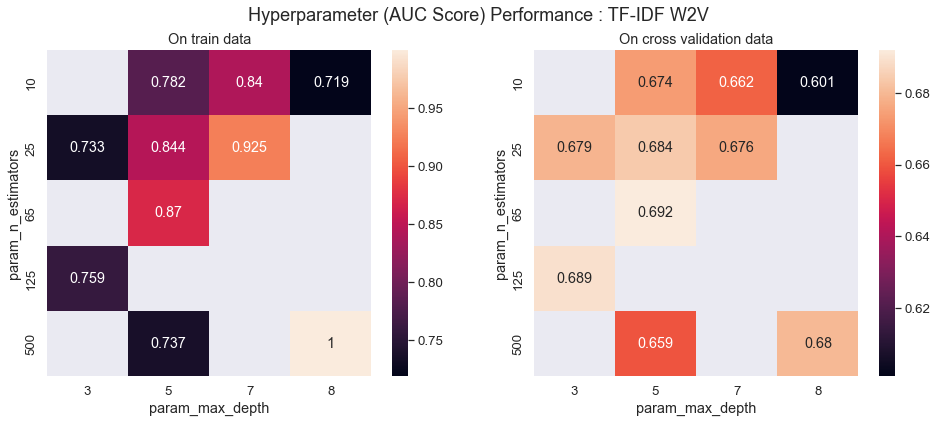

In [69]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.suptitle('Hyperparameter (AUC Score) Performance : TF-IDF W2V', fontsize = 18)

# https://stackoverflow.com/a/39133654
    
fig_1 = sns.heatmap(group_perf_w2v.mean_train_score, annot = True, fmt='.3g', ax = axes[0])
fig_1.title.set_text('On train data')

fig_2 = sns.heatmap(group_perf_w2v.mean_test_score, annot = True, fmt='.3g', ax = axes[1])
fig_2.title.set_text('On cross validation data')

plt.show()

**<font color='red'>Observation</font>**

- While `n_estimators = 65` and `max_depth = 5`, we are getting an **AUC** of **0.87**.
- So we are taking `n_estimators = 65` and `max_depth = 5` as the best parameter.

### <font color = 'blue'>Training Using Best Hyperparameter</font>

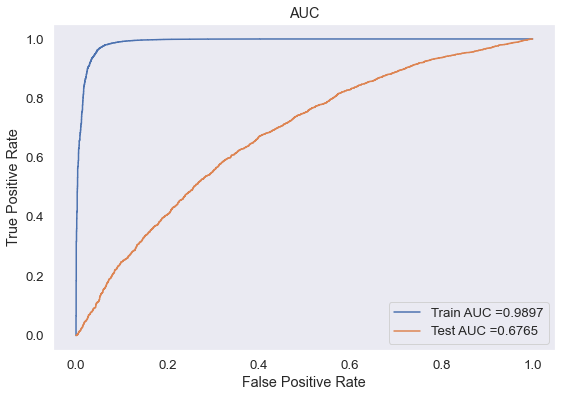

In [70]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

tfidf_w2v_gbdt = GradientBoostingClassifier(
                    n_estimators = tfidf_w2v_n_estimators, max_depth = tfidf_w2v_max_depth,
                    learning_rate = tfidf_w2v_learning_rate)

tfidf_w2v_gbdt.fit(tfidf_w2v_stack_train, y_train)

y_train_pred_tfidf_w2v = tfidf_w2v_gbdt.predict_proba(tfidf_w2v_stack_train)[:,1]
y_test_pred_tfidf_w2v = tfidf_w2v_gbdt.predict_proba(tfidf_w2v_stack_test)[:,1]

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf_w2v)

auc_train_set2 = auc(train_fpr, train_tpr)
auc_test_set2 = auc(test_fpr, test_tpr)

#Reference : DonorchooseNB assignment
plt.figure(figsize = (9,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc_train_set2,4)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(round(auc_test_set2,4)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.grid()
plt.legend(loc=4)
plt.show()

### <font color = 'blue'>Train & Test Confusion Matrix</font>

Train
=====
The maximum value of tpr*(1-fpr) 0.91907 for threshold 0.797


100%|████████████████████████████████| 25200/25200 [00:00<00:00, 2534808.88it/s]



Test
====
The maximum value of tpr*(1-fpr) 0.40235 for threshold 0.869


100%|████████████████████████████████| 10800/10800 [00:00<00:00, 3133325.25it/s]


Train confusion matrix : 
 [[ 3682   197]
 [  677 20644]]

Test confusion matrix : 
 [[ 997  666]
 [3005 6132]]


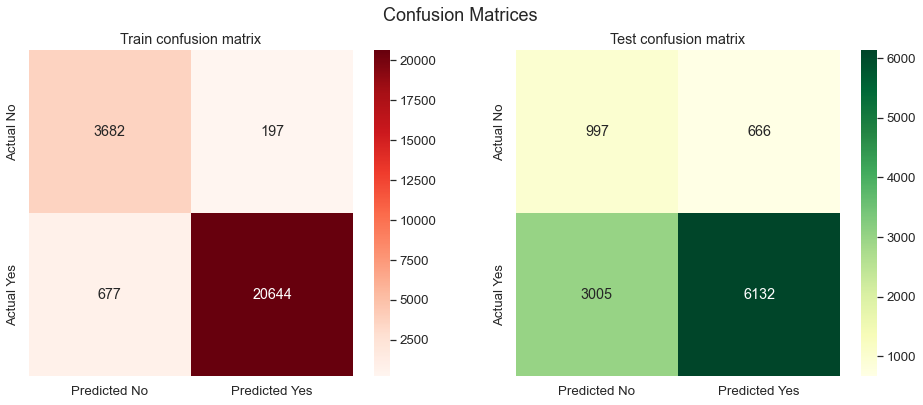

In [76]:
print('Train')
print('=' * 5)
tfidf_w2v_tr_thr, tfidf_w2v_tr_pred = best_threshold_and_y_pred(tr_thresholds,
                                                        y_train_pred_tfidf_w2v, train_fpr, train_tpr)
confusion_mat_tfidf_w2v_tr = confusion_matrix(y_train, tfidf_w2v_tr_pred)

print('\nTest')
print('=' * 4)
tfidf_w2v_te_thr, tfidf_w2v_te_pred = best_threshold_and_y_pred(te_thresholds,
                                                            y_test_pred_tfidf_w2v, test_fpr, test_tpr)
confusion_mat_tfidf_w2v_te = confusion_matrix(y_test, tfidf_w2v_te_pred)

print('\nTrain confusion matrix : \n', confusion_mat_tfidf_w2v_tr)
print('\nTest confusion matrix : \n', confusion_mat_tfidf_w2v_te)

# https://stackoverflow.com/a/61748695
# https://stackoverflow.com/a/39133654

sns.set(font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.suptitle('Confusion Matrices', fontsize = 18)

fig_1 = sns.heatmap(confusion_mat_tfidf_w2v_tr, annot=True, fmt="d", cmap='Reds', ax = axes[0])
fig_1.title.set_text('Train confusion matrix')
axes[0].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[0].set_yticklabels(['Actual No', 'Actual Yes'])

fig_2 = sns.heatmap(confusion_mat_tfidf_w2v_te, annot=True, fmt="d", cmap='YlGn', ax = axes[1])
fig_2.title.set_text('Test confusion matrix')
axes[1].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[1].set_yticklabels(['Actual No', 'Actual Yes'])
plt.show()

**<font color='red'>Observation</font>**

- Train AUC (0.9897) is higher than the Test AUC (0.6765) score.
- We can consider this as overfitting.
- We can conisder more number of points for training model to avoid overfitting.
- Ratio of `True Positive` to `total data in train data` is 81.92% and while for `test data` the same ratio is only 56.77%.
- The **False Positive** (666) on `test data` is lesser than **False Negative** (3005) value which is not good.

NB : While testing for very samll number of datapoints (1000, 2000 and 3000) the train AUC was 1.0 and Test AUC was in a range of 0.45 to 0.6. On increasing numberof datapoints model is showing a good behaviour. So training model at larger datapoints may can avoid overfitting tendency.

<h1>3. Summary</h1>

As mentioned in the step 4 of instructions

In [73]:
time_end = time.time()

In [74]:
# https://pypi.org/project/prettytable/

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'n_estimators', 'max_depth',
                                     'learning_rate','AUC (Train)', 'AUC (Test)']

x.add_row(['TF-IDF', ' GBClassifier ', tfidf_n_estimators, tfidf_max_depth,
                           tfidf_learning_rate, round(auc_train_set1, 2), round(auc_test_set1, 2)])

x.add_row(['TF-IDF W2V', ' GBClassifier ', tfidf_w2v_n_estimators, tfidf_w2v_max_depth,
                           tfidf_w2v_learning_rate, round(auc_train_set2, 2), round(auc_test_set2, 2)])


print(f'Processing Time : {round((time_processing - time_start) / 60, 1)} minutes')
print(f'GBDT Alone      : {round((time_end - time_processing) / 60, 1)} minutes')
print(f'Total Time      : {round((time_end - time_start) / 60, 1)} minutes\n')

print(x)

Processing Time : 1.1 minutes
GBDT Alone      : 262.3 minutes
Total Time      : 263.4 minutes

+------------+----------------+--------------+-----------+---------------+-------------+------------+
| Vectorizer |     Model      | n_estimators | max_depth | learning_rate | AUC (Train) | AUC (Test) |
+------------+----------------+--------------+-----------+---------------+-------------+------------+
|   TF-IDF   |  GBClassifier  |     250      |     7     |      0.1      |     0.98    |    0.68    |
| TF-IDF W2V |  GBClassifier  |      65      |     5     |     0.075     |     0.99    |    0.68    |
+------------+----------------+--------------+-----------+---------------+-------------+------------+


## <font color='red'>Conclusion</font>

- Train AUC is higher than the Test AUC score both models.
- The train AUC is almost near to 1 and while the test AUC is in near to 0.7
- We can consider this as an indication of overfitting.
- We can conisder more number of points for training model to avoid overfitting.
- For both models the ratio of `True Positive` to `total data in train data` is ~80% and while for `test data` the same ratio is only ~56%, the **False Positive** on `test data` is lesser than **False Negative** value which is not good.

**NB** : While testing for very samll number of datapoints (1000, 2000 and 3000) the train AUC was 1.0 and Test AUC was in a range of 0.45 to 0.6. On increasing numberof datapoints model is showing a good behaviour. So training model at larger datapoints may can avoid overfitting tendency.